In [2]:
import boto3
import pandas as pd
from io import StringIO

def load_all_csvs_from_s3(bucket_name):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)

    dfs = []

    for obj in bucket.objects.all():
        if obj.key.endswith('.csv') and obj.key.startswith('data'):
            data = obj.get()['Body'].read().decode('utf-8')
            df = pd.read_csv(StringIO(data))
            dfs.append(df)

    final_df = pd.concat(dfs, ignore_index=True)

    return final_df

df = load_all_csvs_from_s3('dipy-parallel-tests')

cost_df = pd.read_csv('machine_prices.csv')

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# quickly make a linear regression for cpus and cost
# we need this becasuse someof the tested numbers of,
# cpus dont have actualy machines available on aws

x = cost_df.loc[:, ['cpus']]
y = cost_df.loc[:, ['cost']]

#linear regression
poly_reg_1 = PolynomialFeatures(degree=1)
x_poly_1 = poly_reg_1.fit_transform(x)
lin_reg_1 = LinearRegression()
lin_reg_1.fit(x_poly_1, y)



LinearRegression()

                             model        time   hr_cost  total_cost cpus
0  ConstrainedSphericalDeconvModel   11.788321  1.375766    0.004505   32
1  ConstrainedSphericalDeconvModel   11.536030  2.061250    0.006605   48
2  ConstrainedSphericalDeconvModel   11.538867  3.089476    0.009903   72
3  ConstrainedSphericalDeconvModel   22.077673  0.347540    0.002131    8
4  ConstrainedSphericalDeconvModel   14.672244  0.690282    0.002813   16
5             FreeWaterTensorModel   44.687911  1.375766    0.017078   32
6             FreeWaterTensorModel   40.760232  2.061250    0.023338   48
7             FreeWaterTensorModel   31.475660  3.089476    0.027012   72
8             FreeWaterTensorModel  106.501855  0.347540    0.010282    8
9             FreeWaterTensorModel   60.897872  0.690282    0.011677   16


/var/folders/gb/604kkgfn2cj2q1bp1zw3t56m0000gn/T/ipykernel_15448/4193019617.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  avg_df = pd.concat([avg_df, new_row], ignore_index=True)
/var/folders/gb/604kkgfn2cj2q1bp1zw3t56m0000gn/T/ipykernel_15448/4193019617.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([final_df, new_row], ignore_index=True)


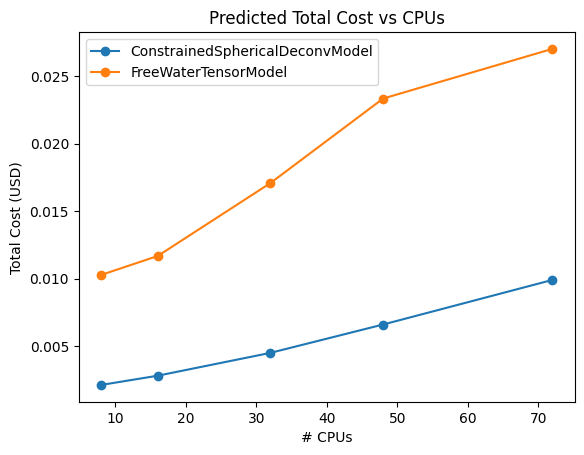

In [5]:
avg_df = pd.DataFrame(columns=['model','cpus','num_chunks','time','time_std'])
final_df = pd.DataFrame(columns=['model','time','hr_cost','total_cost','cpus'])

# fill avg_df with average time for each model, cpus, and num_chunks
for model in df['model'].unique():
    model_df = df[df['model'] == model]
    for cpu in model_df['cpu_count'].unique():
        cpu_df = model_df[model_df['cpu_count'] == cpu]
        for num_chunks in cpu_df['num_chunks'].unique():
            chunk_df = cpu_df[cpu_df['num_chunks'] == num_chunks]

            avg_time = chunk_df['time'].mean()
            time_std = chunk_df['time'].std()
            new_row = pd.DataFrame({'model': [model], 'cpus': [cpu], 'num_chunks': [num_chunks], 'time': [avg_time], 'time_std': [time_std]})
            avg_df = pd.concat([avg_df, new_row], ignore_index=True)



for model in avg_df['model'].unique():
    model_df = avg_df[avg_df['model'] == model]
    for cpu in model_df['cpus'].unique():
        cpu_df = model_df[model_df['cpus'] == cpu]
        time = cpu_df['time'].min()
        cost = lin_reg_1.predict(poly_reg_1.fit_transform([[cpu]]))[0][0]
        total_cost = cost * ((time/60)/60)

        new_row = pd.DataFrame({'model': [model], 'time': [time], 'hr_cost': [cost], 'total_cost': [total_cost], 'cpus': [cpu]})
        final_df = pd.concat([final_df, new_row], ignore_index=True)

import matplotlib.pyplot as plt

print(final_df)

# Create a plot for each unique model
for model in final_df['model'].unique():
    model_df = final_df[final_df['model'] == model]
    model_df = model_df.sort_values(by='cpus')
    plt.plot(model_df['cpus'], model_df['total_cost'], 'o-', label=model)

# Set the plot title and labels
plt.title('Predicted Total Cost vs CPUs')
plt.xlabel('# CPUs')
plt.ylabel('Total Cost (USD)')

# Add a legend
plt.legend()

# Show the plot
plt.show()

